<h1 style="color:red">Load necessary Packages</h1> 

In [1]:
from pyspark.sql import SparkSession
# pyspark functions 
from pyspark.sql.functions import when, col, sum, count, isnan, udf, mean
import pyspark.sql.functions as F

# for statistics
from pyspark.mllib.stat import Statistics
# for features selections 
from pyspark.ml.feature import VectorAssembler
# for standarization 
from pyspark.ml.feature import MinMaxScaler
## For evaluate model 
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
## For Logistic regression 
from pyspark.ml.classification import LogisticRegression
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from pprint import pprint

<h1 style ="color:red">Create a spark Session</h1>

In [4]:
spark = SparkSession.builder.appName("LogisticRegression").getOrCreate()

In [3]:
data= spark.read.csv("dataset/diabetes.csv", header= True, inferSchema=True)
data.toPandas().head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


<h1 style ="color:red">Data Mining </h1>

In [11]:
data_describe = data.describe().toPandas()
data_describe.index = data_describe["summary"]
data_describe.drop("summary", axis = 1, inplace=True)
data_describe = data_describe.T
data_describe

summary,count,mean,stddev,min,max
Pregnancies,768,3.8450520833333335,3.36957806269887,0,17
Glucose,768,120.89453125,31.97261819513622,0,199
BloodPressure,768,69.10546875,19.355807170644777,0,122
SkinThickness,768,20.536458333333332,15.952217567727642,0,99
Insulin,768,79.79947916666667,115.24400235133803,0,846
BMI,768,31.992578124999977,7.884160320375441,0.0,67.1
DiabetesPedigreeFunction,768,0.4718763020833327,0.331328595012775,0.078,2.42
Age,768,33.240885416666664,11.760231540678689,21,81
Outcome,768,0.3489583333333333,0.476951377242799,0,1


<h1 style ="color:red">Data visualization </h1>

<h2 style = "color:green"> Fonction</h2>

In [5]:
## Function to visualize the histogramm
def histogramm_visualization (data):
    """
    This function displays histograms of all variables in the data.
    """
    fig = plt.figure(figsize=(25,20))
    st = fig.suptitle("Distribution of Features", fontsize =50, verticalalignment = "center")
    for col, num in zip(data.columns, range(1,11)): 
        ax = fig.add_subplot(3,4,num)
        ax.hist(data[col])
        plt.grid(False)
        plt.xticks(rotation = 45, fontsize = 20)
        plt.yticks(fontsize = 15)
        plt.title(col.upper(), fontsize = 15, color = "red")
    plt.tight_layout()
    st.set_y(0.95)
    fig.subplots_adjust(top = 0.85, hspace = 0.4)
    plt.show()


In [6]:
def pairplot_viualization(data, hue_col): 
    sns.pairplot(data = data, hue = hue_col)

In [7]:
def distribution_visualization(data, size): 
    """
    This function displays distribution of all features in the data.
    
    """
    plt.subplots(3,3, figsize =(size))
    plt.suptitle("Distribution of Features", fontsize =50, verticalalignment = "center")
    ## plot density plot for earch variable 7
    for idx, col in enumerate(data.columns): 
        ax = plt.subplot(3,3, idx +1)
        ax.yaxis.set_ticklabels([])
        sns.kdeplot(data.loc[data.Outcome ==0][col], warn_singular= False)
        sns.kdeplot(data.loc[data.Outcome ==1][col], warn_singular=False)
        ax.set_title(col)
    plt.subplot(3,3,9).set_visible(False)
    plt.subplots_adjust(top = 0.85, hspace = 0.4)

    plt.show()

In [8]:
def heatmap_visualization(data, annotation, cbar, size): 
    """
        This function displays the heatmap

    """
    f, ax = plt.subplots(figsize = size)
    sns.heatmap(data, cbar=cbar, cmap='GnBu', yticklabels=False, annot=annotation)
    ax.set_xticklabels(
            ax.get_xticklabels(), 
            rotation = 45, 
                horizontalalignment = 'right')

<h2 style ="color:green"> Call function </h2>

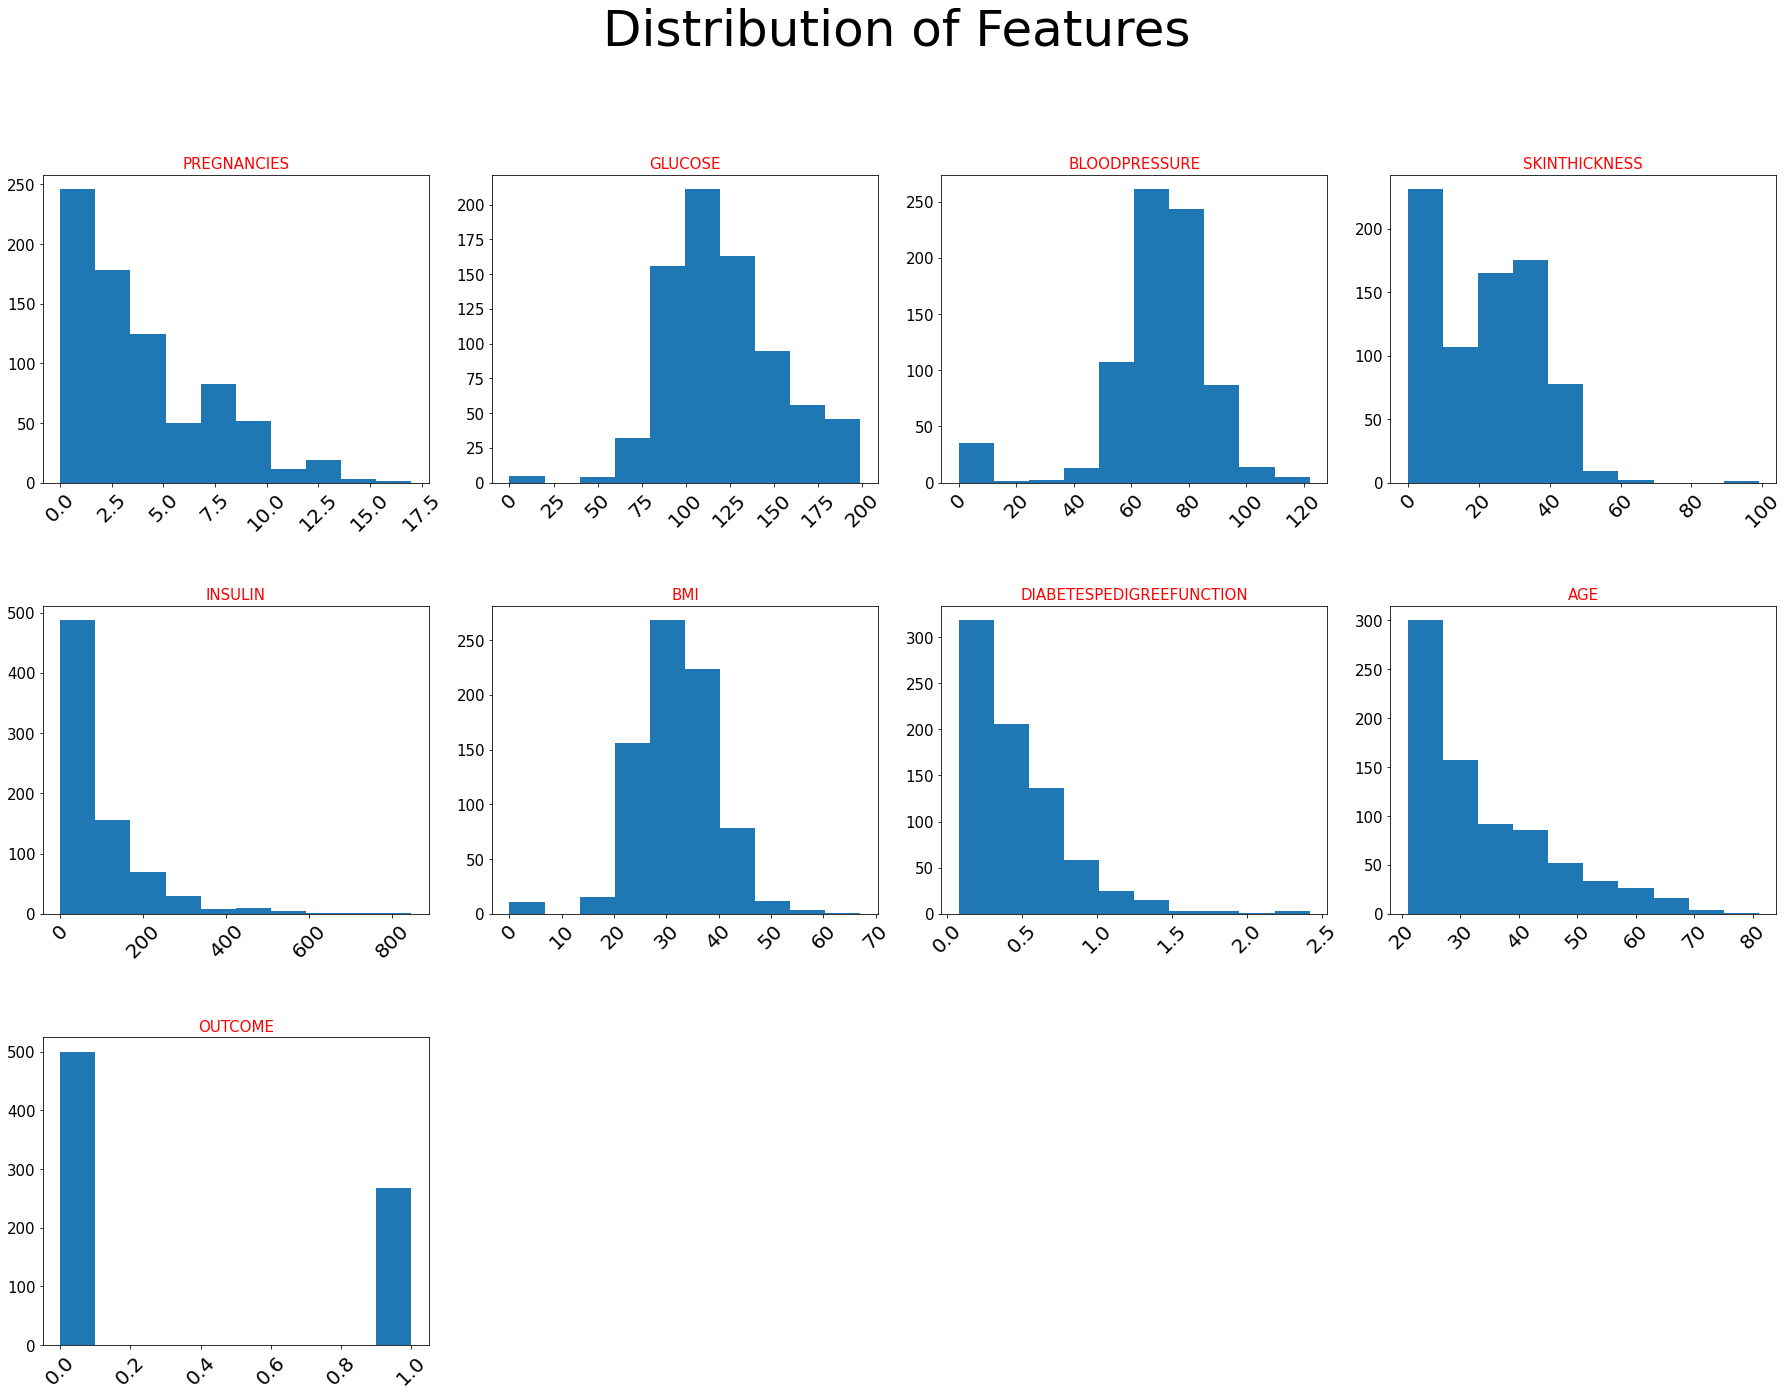

In [9]:
histogramm_visualization(data.toPandas())

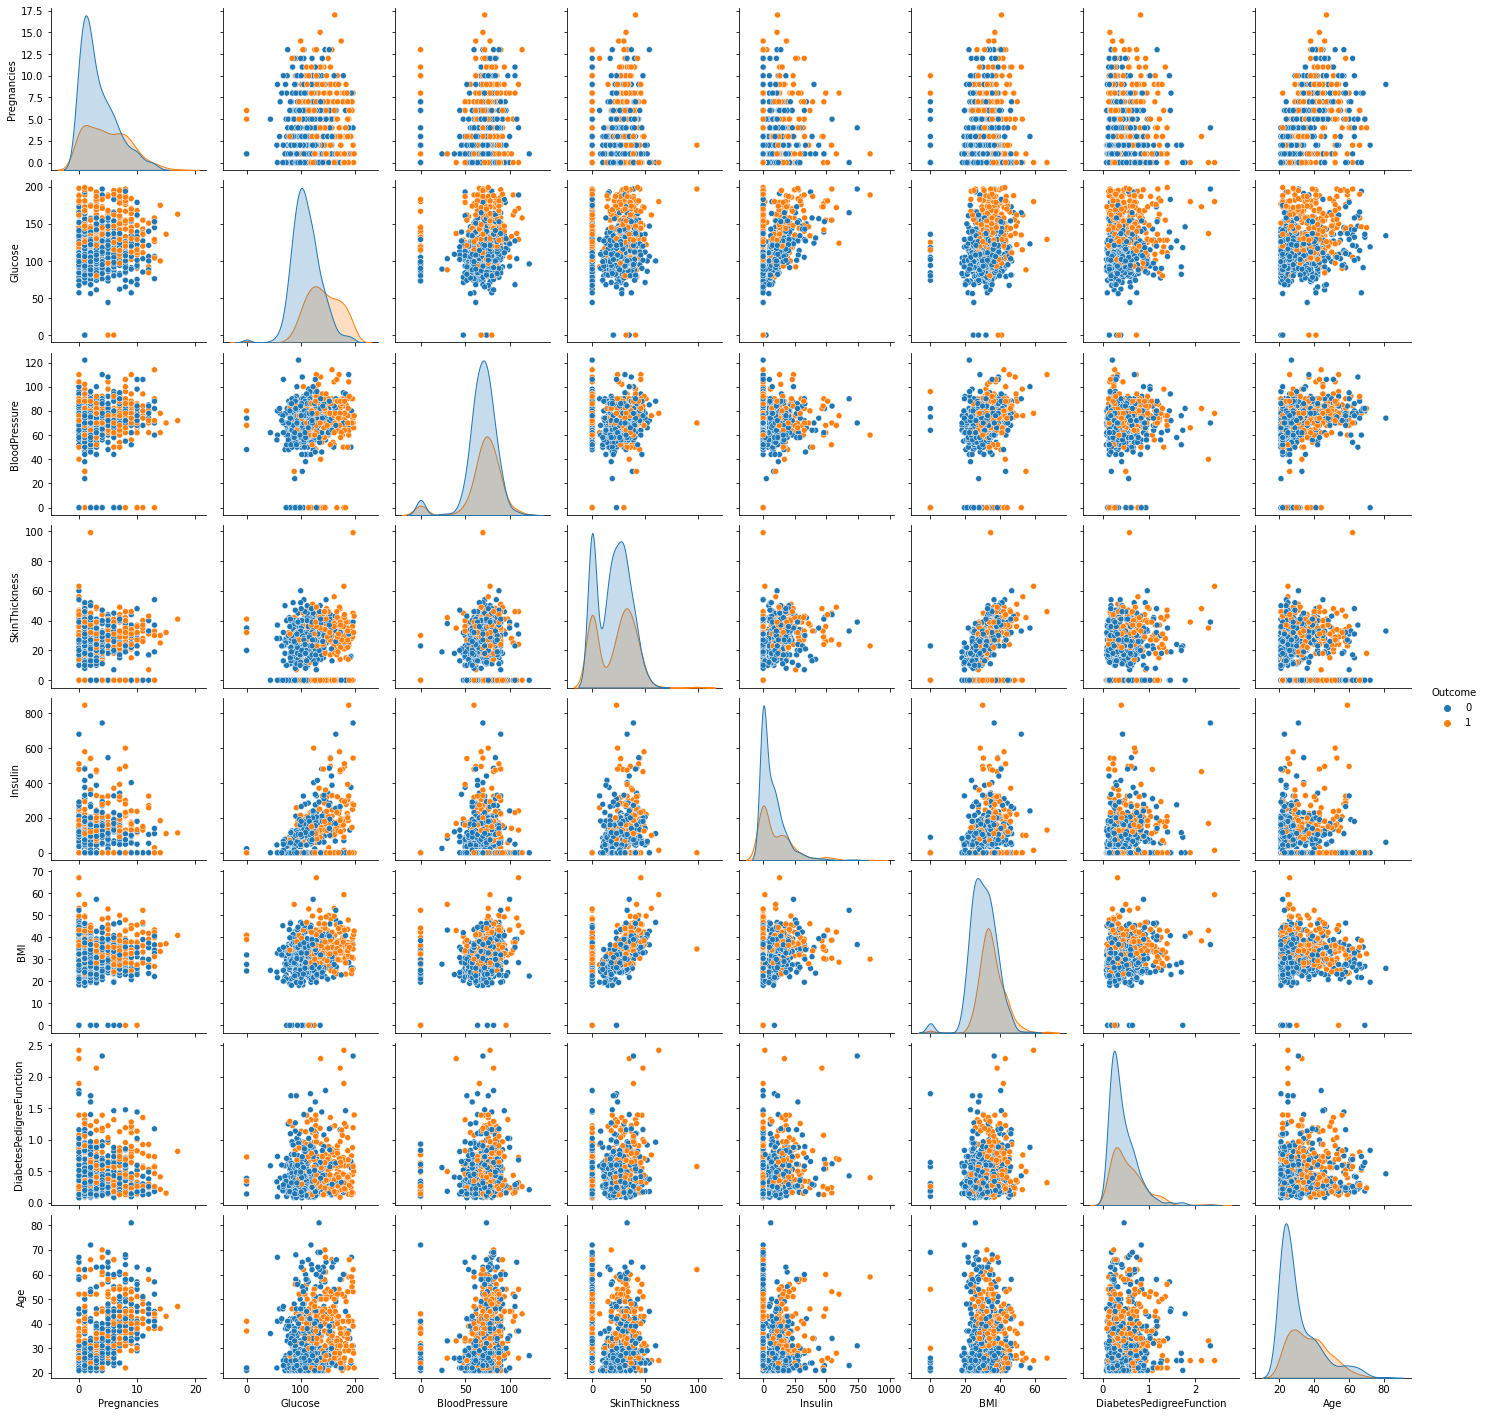

In [10]:
# Call function 
pairplot_viualization(data.toPandas(), hue_col="Outcome")   


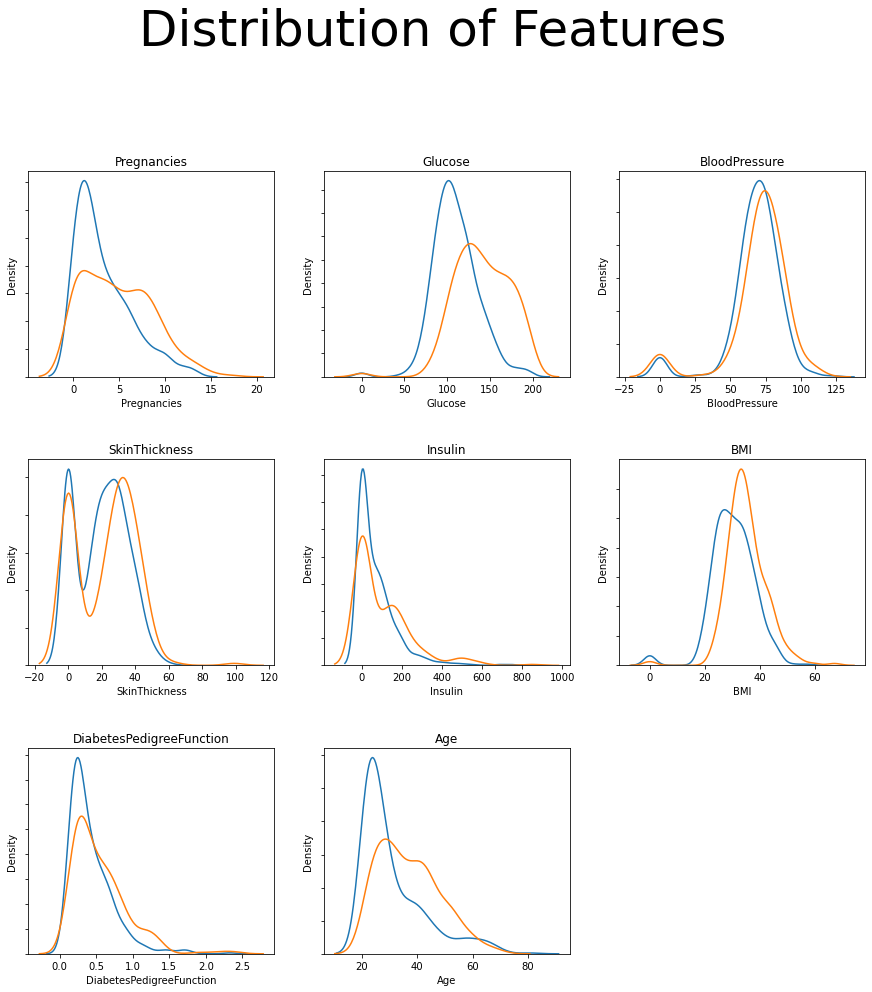

In [11]:
# Call function 
distribution_visualization(data.toPandas(), (15,15))

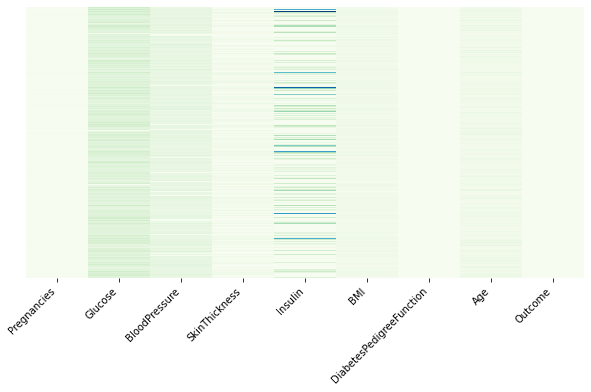

In [12]:
# call function 
heatmap_visualization(data.toPandas(), cbar= False, annotation = False, size = (10,5))

<h1 style = "color:red"> Data Preprocessing </h1>

In [13]:
# Check for null values 
for col in data.columns: 
    print(f"{col} : {data[data[col].isNull()].count()}")

Pregnancies : 0
Glucose : 0
BloodPressure : 0
SkinThickness : 0
Insulin : 0
BMI : 0
DiabetesPedigreeFunction : 0
Age : 0
Outcome : 0


In [14]:
# check the NaN values in dataset 
data.select([count(when(isnan(c),c)).alias(c) for c in data.columns]).toPandas()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0,0,0,0,0,0,0,0,0


In [15]:
def transform_age(age):
    """
    This function transforms age into a category variable 
    """
    if (age <25): 
        return 'Under 25'
    elif (age >=25 and age <= 35): 
        return "Between 25 and 35"
    elif (age >35 and age <50): 
        return 'Between 36 and 50'
    elif (age >= 50): 
        return "Over 50"
    else: return "NA"
## Show the documentation of the function 
print(transform_age.__doc__)


    This function transforms age into a category variable 
    


In [16]:
# Call function
age_udf = udf(transform_age)
data = data.withColumn("age_tr",age_udf("Age"))
data.toPandas().head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,age_tr
0,6,148,72,35,0,33.6,0.627,50,1,Over 50
1,1,85,66,29,0,26.6,0.351,31,0,Between 25 and 35
2,8,183,64,0,0,23.3,0.672,32,1,Between 25 and 35
3,1,89,66,23,94,28.1,0.167,21,0,Under 25
4,0,137,40,35,168,43.1,2.288,33,1,Between 25 and 35


<h2 style = "color:green"> Univariate statistics</h2>

In [17]:
## Les différentes cathégories de label
Name_outcome = ["Diabetes", "No Diabetes"]
Name_age = data.toPandas()['age_tr'].value_counts().index.to_list()
palette = ["#fee090", "#fdae61", "#008080", "#808000", "#FF00FF"]
colours = {"Diabetes": "#fee090", 
            "No Diabetes" : "#fdae61"
    
}
print(Name_age)

['Between 25 and 35', 'Under 25', 'Between 36 and 50', 'Over 50']


In [18]:
def label_colour (Name, palette):
    """
    Create the color for earch category
    """
    dict_colour = {}
    for i in range(len(Name)):
        dict_colour[Name[i]] = palette[i]
    return dict_colour
## call function
dict_colour_outcome = {}
dict_colour_outcome = label_colour(Name_outcome, palette = palette)
print(dict_colour_outcome)
print("\n")
print("\n")
dict_colour_age = label_colour(Name_age, palette = palette)
print(dict_colour_age)

{'Diabetes': '#fee090', 'No Diabetes': '#fdae61'}




{'Between 25 and 35': '#fee090', 'Under 25': '#fdae61', 'Between 36 and 50': '#008080', 'Over 50': '#808000'}


In [19]:
def Visualizing_Categorical_Variable(data, col, size, Name, colors): 
    """
    This function displays cathegory variables in barplot and Pie chart form. 
    """
    values = data[col].value_counts()
    labels = data[col].value_counts().index
    plt.figure(figsize=size)
    plt.suptitle(f"Distribution of {col}", fontsize =50, verticalalignment = "center")

    ## barplot 
    plt.subplot(2,2,1)
    plt.bar(Name,values, color=palette)
    for index, value in enumerate(values): 
        plt.text(x = index, y = value+0.02, s = f"{value}", fontdict=dict(fontsize=15), color = "blue")
    plt.title("Barplot Visualization")
    ## Pie plot 
    plt.subplot(2,2,2)
    plt.title(f"Pie chart", fontsize = 20)
    plt.pie(values, labels= Name, autopct="%.2f%%", shadow=True, textprops={"fontsize":20}, 
            colors = [colors[key]  for key in Name] )
    plt.axis("equal")
    plt.tight_layout()
    plt.legend()
    plt.show()

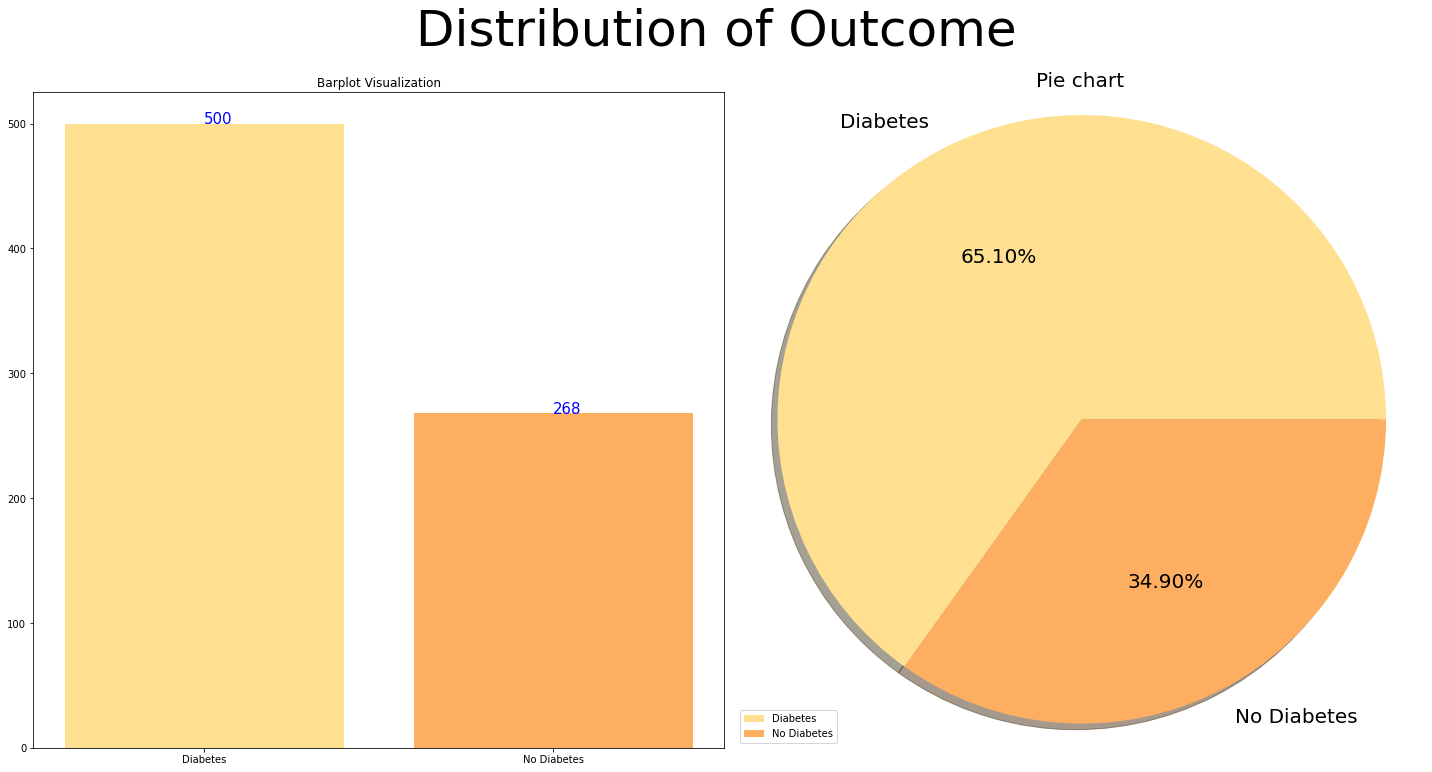

In [20]:
## Call function
Visualizing_Categorical_Variable(data.toPandas(), "Outcome", (20,20), Name_outcome,dict_colour_outcome)

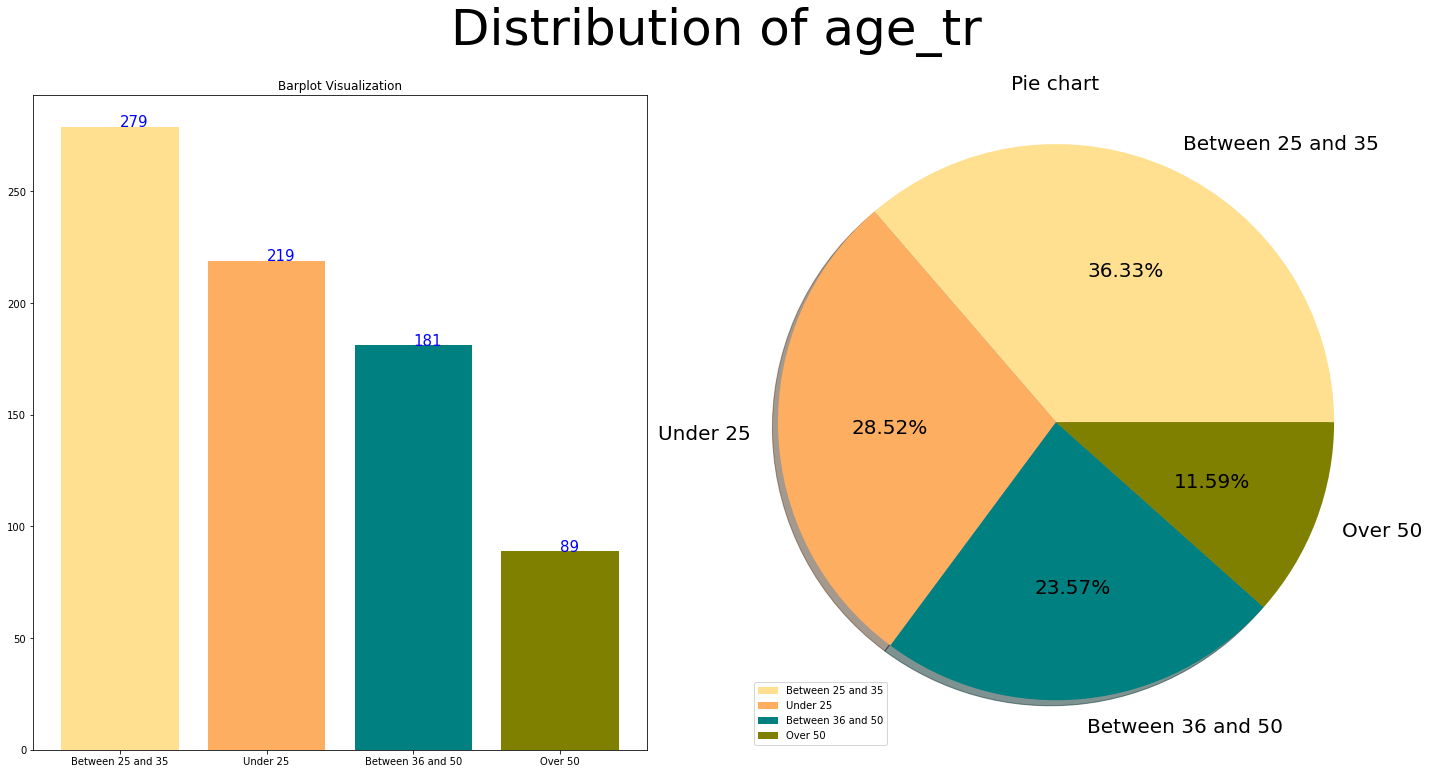

In [21]:
# Call function for age variable 
Visualizing_Categorical_Variable(data.toPandas(), "age_tr", (20,20), Name_age,dict_colour_age)

<h3 style = "color:green"> Distribution of histogram </h3>

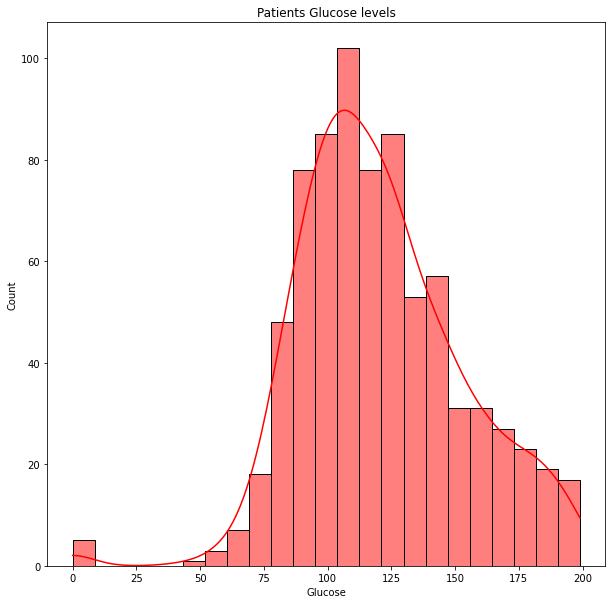

In [22]:
plt.figure(figsize=(10,10))
sns.histplot(data.toPandas()["Glucose"], stat="count", color = "red", kde="True")
plt.title("Patients Glucose levels")
plt.xlabel("Glucose")
plt.show()

<h3  style = "color:green">Count the number of zeros in earch columns</h3>

In [23]:
# Select the numeric columns in dataset 
dataset = data.select([col[0] for col in data.dtypes if col[1] != "string"])
df_zero = dataset.select([F.count(F.when(dataset[c] ==0, c)).alias(c) for c in dataset.columns])
df_zero.toPandas()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,111,5,35,227,374,11,0,0,500


<h3 style = "color:green">Filter out rows with zeros</h3>

In [25]:
from pyspark.sql.functions import col

dataset = data.filter((col("Glucose") !=0) &  (col("BloodPressure") !=0) & (col("BMI") !=0))
## Show the result
dataset.toPandas().head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,age_tr
0,6,148,72,35,0,33.6,0.627,50,1,Over 50
1,1,85,66,29,0,26.6,0.351,31,0,Between 25 and 35
2,8,183,64,0,0,23.3,0.672,32,1,Between 25 and 35
3,1,89,66,23,94,28.1,0.167,21,0,Under 25
4,0,137,40,35,168,43.1,2.288,33,1,Between 25 and 35


In [49]:
nb_zeros_values = data.count()- dataset.count() 
print(nb_zeros_values)

44


 <h3 style = "color:green"> Calculate and replace the unnecessary values by the mean value</h3>

In [26]:
# Calculate and replace the unnecessary values by the mean value
for col in dataset.columns[1:6]: 
    mean_col = dataset.agg({col: "mean"}).first()[0]
    print(f"Mean value for {col} :  {mean_col}")
    dataset = dataset.withColumn(col, when(dataset[col]==0, int(mean_col)).otherwise(dataset[col]))


Mean value for Glucose :  121.88259668508287
Mean value for BloodPressure :  72.40055248618785
Mean value for SkinThickness :  21.443370165745858
Mean value for Insulin :  84.49447513812154
Mean value for BMI :  32.46712707182319


<h1  style ="color:red"> Pearson Correalation</h1>

In [27]:
# get the numeric columns in dataset 
numeric_features = [t[0] for t in data.dtypes if t[1] != "string"]
numeric_features.remove("Outcome")
numeric_features_df = dataset.select(numeric_features)
# Show data 
numeric_features_df.toPandas().head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,84,33.6,0.627,50
1,1,85,66,29,84,26.6,0.351,31
2,8,183,64,21,84,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33


In [29]:
# Tranform data to rdd 
col_names = numeric_features_df.columns
features  = numeric_features_df.rdd.map(lambda row : row[0:])
features.take(10)

[(6, 148, 72, 35, 84, 33.6, 0.627, 50),
 (1, 85, 66, 29, 84, 26.6, 0.351, 31),
 (8, 183, 64, 21, 84, 23.3, 0.672, 32),
 (1, 89, 66, 23, 94, 28.1, 0.167, 21),
 (0, 137, 40, 35, 168, 43.1, 2.288, 33),
 (5, 116, 74, 21, 84, 25.6, 0.201, 30),
 (3, 78, 50, 32, 88, 31.0, 0.248, 26),
 (2, 197, 70, 45, 543, 30.5, 0.158, 53),
 (4, 110, 92, 21, 84, 37.6, 0.191, 30),
 (10, 168, 74, 21, 84, 38.0, 0.537, 34)]

<h2 style = "color:green"> Calculate the correlation matrix</h2>

In [31]:
corr_mat= Statistics.corr(features, method='pearson')
corr_df = pd.DataFrame(corr_mat)
corr_df.index = col_names
corr_df.columns = col_names
corr_df = round(corr_df, 2)
display(corr_df)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Pregnancies,1.00,0.13,0.21,0.01,-0.02,0.01,-0.03,0.56
Glucose,0.13,1.00,0.22,0.16,0.41,0.22,0.14,0.26
BloodPressure,0.21,0.22,1.00,0.13,0.01,0.29,-0.00,0.32
SkinThickness,0.01,0.16,0.13,1.00,0.22,0.55,0.15,0.03
Insulin,-0.02,0.41,0.01,0.22,1.00,0.19,0.16,0.04
BMI,0.01,0.22,0.29,0.55,0.19,1.00,0.15,0.02
DiabetesPedigreeFunction,-0.03,0.14,-0.00,0.15,0.16,0.15,1.00,0.02
Age,0.56,0.26,0.32,0.03,0.04,0.02,0.02,1.00


<h2 style="color:green"> Heatmap visualization</h2>

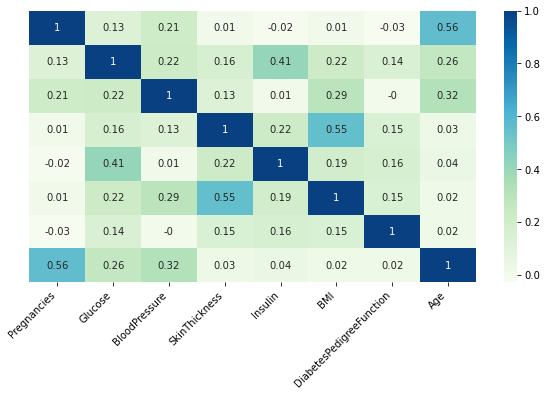

In [32]:
heatmap_visualization(corr_df, cbar=True, annotation = True, size = (10,5))

In [ ]:
## Order features 
plt.figure(figsize=(10,10))
ax = sns.heatmap(corr_df, vmin=-1, vmax= 1, center=0, cmap="GnBu", square=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, 
                horizontalalignment = "right")
plt.show()

<h1 style = "color:red"> Logistic Regression </h1>

<h2 style = "color:green" >Features Selection</h2>

In [34]:
assembler = VectorAssembler(inputCols= numeric_features, 
                           outputCol= "features")
## Get the outpudata 
output_data = assembler.transform(dataset)
## Scale the imput columns using MinMaxScaler
scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")
scaled_df = scaler.fit(output_data).transform(output_data)

In [36]:
scaled_df.toPandas().head(2)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,age_tr,features,scaledFeatures
0,6,148,72,35,84,33.6,0.627,50,1,Over 50,"[6.0, 148.0, 72.0, 35.0, 84.0, 33.6, 0.627, 50.0]","[0.3529411764705882, 0.6709677419354839, 0.489..."
1,1,85,66,29,84,26.6,0.351,31,0,Between 25 and 35,"[1.0, 85.0, 66.0, 29.0, 84.0, 26.6, 0.351, 31.0]","[0.058823529411764705, 0.2645161290322581, 0.4..."


<h2 style = "color:green" > Split Dataset</h2>

In [37]:
final_data = scaled_df.select("scaledFeatures", "Outcome")
final_data.toPandas().head()

,scaledFeatures,Outcome
0,"[0.3529411764705882, 0.6709677419354839, 0.489...",1
1,"[0.058823529411764705, 0.2645161290322581, 0.4...",0
2,"[0.47058823529411764, 0.896774193548387, 0.408...",1
3,"[0.058823529411764705, 0.2903225806451613, 0.4...",0
4,"[0.0, 0.6, 0.16326530612244897, 0.304347826086...",1


In [38]:
# Split data 
## 70% for train and 30 for test data
train, test = final_data.randomSplit([0.7,0.3])

In [39]:
print("shape of train data:", train.toPandas().shape)
print("Shape of test data : ",test.toPandas().shape)

shape of train data: (491, 2)
Shape of test data :  (233, 2)


<h2 style = "color:green"> Build Model</h2>

In [40]:
# Train models 
models = LogisticRegression(labelCol= "Outcome", featuresCol="scaledFeatures", regParam=0)
# fit the models
model = models.fit(train)

<h2 style = "color:green" >Summary the result of the model</h2>

In [41]:
summary = model.summary
summary.predictions.describe().toPandas()

,summary,Outcome,prediction
0,count,491,491
1,mean,0.3319755600814664,0.26883910386965376
2,stddev,0.471402561418238,0.4438082834140778
3,min,0.0,0.0
4,max,1.0,1.0


In [48]:
## test model 
prediction = model.transform(test)
prediction.show(10)

+--------------------+-------+--------------------+--------------------+----------+
|      scaledFeatures|Outcome|       rawPrediction|         probability|prediction|
+--------------------+-------+--------------------+--------------------+----------+
|[0.0,0.1935483870...|      0|[3.72166398730387...|[0.97637783075525...|       0.0|
|[0.0,0.2580645161...|      0|[2.66957958815763...|[0.93520756145945...|       0.0|
|[0.0,0.3161290322...|      0|[2.35040031612984...|[0.91296604155748...|       0.0|
|[0.0,0.3161290322...|      0|[2.75202782460451...|[0.94002777163331...|       0.0|
|[0.0,0.3290322580...|      0|[1.35322201052089...|[0.79465588830160...|       0.0|
|[0.0,0.3290322580...|      0|[2.24762327705673...|[0.90444532660422...|       0.0|
|[0.0,0.3483870967...|      0|[3.38788849155616...|[0.96732386910431...|       0.0|
|[0.0,0.3677419354...|      0|[3.50729691972912...|[0.97089467712212...|       0.0|
|[0.0,0.3677419354...|      0|[3.15027363770387...|[0.95891950253330...|    

<h2 style = "color:green" >Evaluate the model</h2>

In [67]:
evaluator = MulticlassClassificationEvaluator(labelCol= "Outcome", 
                                              predictionCol="prediction",
                                              metricName= "logLoss")
loss = evaluator.evaluate(prediction)
print(f"Cross-entropy loss =  {round(loss,3)}")

Cross-entropy loss =  0.463


<h3 style = "color:green" >ROC curve </h3>

In [49]:
trainingSummary = model.summary
modelROC = trainingSummary.roc.toPandas()
display(modelROC)

,FPR,TPR
0,0.000000,0.000000
1,0.000000,0.006135
2,0.003049,0.006135
3,0.003049,0.012270
4,0.003049,0.018405
...,...,...
488,0.990854,1.000000
489,0.993902,1.000000
490,0.996951,1.000000
491,1.000000,1.000000


<h3 style = "color:green" >ROC cuve Visualization </h3>

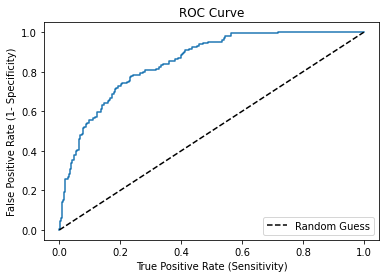

In [44]:
plt.plot(modelROC['FPR'], modelROC["TPR"])
plt.plot([0,1], [0,1], "k--", label = "Random Guess")
plt.ylabel("False Positive Rate (1- Specificity)")
plt.xlabel("True Positive Rate (Sensitivity)")
plt.title("ROC Curve")
plt.legend(loc = "lower right")
plt.show()

In [45]:
print("Training set AreaUnderROC " + str(round(trainingSummary.areaUnderROC,3)))

Training set AreaUnderROC 0.85


 
<h3 style = "color:green" >Confusion Matrix </h3>


In [50]:
from pyspark.sql.functions import col
# Calculate true positive, tru negative, false positive, false negative 
tp = prediction.filter((col("Outcome")==1) & (col("prediction")==1)).count()
tn = prediction.filter((col("Outcome")==0) & (col("prediction")==0)).count()
fp = prediction.filter((col("Outcome")==0) & (col("prediction")==1)).count()
fn = prediction.filter((col("Outcome")==1) & (col("prediction")==0)).count()
print("True positive", tp)
print("True negative", tn)
print("False positive", fp)
print("True negative", fn)
print("\n")
## Calculate the confusion matrix
## Confusion Matrix
confusion_matrix = np.array([[tp, fp], 
                           [fn, tn]])
print(confusion_matrix)

True positive 43
True negative 134
False positive 13
True negative 43


[[ 43  13]
 [ 43 134]]


<h3 style = "color:green" >Heatmap visualization </h3>


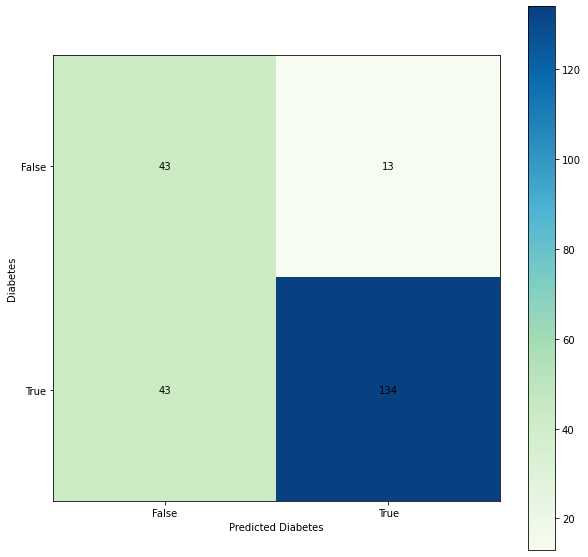

In [51]:
## create a heatmap
plt.figure(figsize=(10,10))

plt.imshow(confusion_matrix, cmap= "GnBu")
# Set the x-axis and y-axis labels 
plt.xticks([0,1],["False", "True"])
plt.yticks([0,1],["False", "True"])
plt.xlabel("Predicted Diabetes")
plt.ylabel("Diabetes")
## Add a color bar to show the scale of the values 
plt.colorbar()
## Add the values to the heatmap 
for i in range(confusion_matrix.shape[0]): 
    for j in range(confusion_matrix.shape[1]): 
        plt.text(j, i, confusion_matrix[i,j], ha = "center", va = "center")

<h3 style = "color:green" >Precision and Recall </h3>


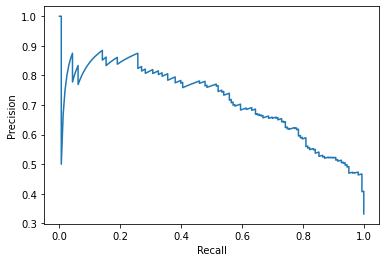

In [52]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr["recall"], pr["precision"])
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.show()

<h3 style = "color:green" >Calculating model parameters</h3>


In [81]:
def traing_model(train, labelCol, featuresCol, regParam):
    ## Instancier le modèle
    model = LogisticRegression(labelCol=labelCol, featuresCol=featuresCol, regParam=regParam)
    ## Entrainer le modèle
    model_trained = model.fit(train)
    ## calcultate the parameters
    model_parameters = {"Intercept" : model_trained.intercept, 
                        "coefficients": model_trained.coefficients, 
                        "max_iter" : model_trained.getOrDefault("maxIter"), 
                        "reg_param" : model_trained.getOrDefault("regParam")
        
    }
    ## return the result 
    return model_parameters
## Call function 
print("\n")
parameters = traing_model(train, labelCol="Outcome", featuresCol="scaledFeatures", regParam=0)
pprint(parameters)



{'Intercept': -5.513588778328865,
 'coefficients': DenseVector([1.6953, 5.5354, -0.8147, 0.0666, 0.1553, 3.9845, 2.6703, 1.0898]),
 'max_iter': 100,
 'reg_param': 0.0}
